## LC Model Search Framework Scikit-Learn

* Compare 1 season (summer) and 4 temporal steps
* Compare 0 - 1500 training training samples per class in 100 sample increments
* CNN component and RNN components in isolation
* regular CNN+RNN vs conv2dlstm and RNN vs just conv2dLSTM
* Compare to scikit-learn methods using same val and test datasets
* Compare best model across time
    * if major decrease in accuracy then consider training on both 2010 and 2011 data for initial time step
        * consider training on 1999 data to see how it changes the model

In [1]:
import comet_ml
from comet_ml import Experiment
import datetime
import rasterio
import keras
import pandas as pd
import seaborn as sns
import random
from keras import backend as K
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Reshape, Bidirectional
from keras.layers import Conv2D, MaxPooling2D, MaxPooling3D, ConvLSTM2D, TimeDistributed, UpSampling2D, Concatenate, LSTM, concatenate
from keras.layers import Activation, BatchNormalization
from keras.optimizers import SGD, Adadelta, Adam
from keras import Input
from keras import Model
import matplotlib.pyplot as plt
import geopandas as gpd
import os
import sys
from sklearn.utils import class_weight
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import utilities as util
import importlib
import rnn_tiles
import rnn_pixels
import numpy as np

Using TensorFlow backend.


In [2]:
importlib.reload(rnn_pixels)
importlib.reload(rnn_tiles)
importlib.reload(util)

<module 'utilities' from '/host/Code/florence_mapping/utilities.py'>

In [3]:
exp_name = 'fullval_sklearn'
model_name = 'rf_1'

Ingest Training Labels

Note that these are monster files so be careful how you inspect them, typically you only want to use the `rasterio` windows option

In [4]:
lc_labels = rasterio.open('/deep_data/recurrent_data/NLCD_DATA/landcover/NLCD_2011_Land_Cover_L48_20190424.img')
canopy_labels = rasterio.open('/deep_data/recurrent_data/NLCD_DATA/canopy/CONUSCartographic_2_8_16/Cartographic/nlcd2011_usfs_conus_canopy_cartographic.img')
class_dict = util.indexed_dictionary

Ingest the landsat imagery stacked into yearly seasonal tiles

In [5]:
tiles = {}
landsat_datasets = {}
tiles['028012'] = ['20110103', '20110308', '20110730', '20110831', '20111103']
tiles['029011'] = ['20110103', '20110308', '20110730', '20110831', '20111018']
tiles['028011'] = ['20110103', '20110308', '20110831', '20111018', '20111103']

# tiles['028012'] = ['20110730']
# tiles['029011'] = ['20110730']
# tiles['028011'] = ['20110831']

# 2000 tiles
# updated tiles
#tiles['028012'] = ['20000105', '20000410', '20000816', '20001003', '20001019']
#tiles['029011'] = ['20000222', '20000410', '20000816', '20001003', '20001019']
#tiles['028011'] = ['20000121', '20000410', '20000512', '20000816', '20001019']

#tiles['028012'] = ['20000816']
#tiles['029011'] = ['20000816']
#tiles['028011'] = ['20000816']

for tile_number, dates in tiles.items():
    tile_datasets = []
    l8_image_paths = []
    for date in dates:
        l8_image_paths.append('/deep_data/recurrent_data/tile{}/combined/combined{}.tif'.format(tile_number, date))
    for fp in l8_image_paths:
        tile_datasets.append(rasterio.open(fp))
    landsat_datasets[tile_number] = tile_datasets

### Load pixels from shapefiles

In [6]:
train_gdf = gpd.read_file('../shapefiles/train_buffered_points140520.shp')
train_px = []
for index, row in train_gdf.iterrows():
    train_px.append(((row['row'], row['col']), row['tile_name'], row['label']))

random.shuffle(train_px)

len(train_px), train_px[0]

(9000, ((1418, 3403), '028012', 1))

In [7]:
val_gdf = gpd.read_file('../shapefiles/val_buffered_points140520_val.shp')
val_px = []

per_class_count = [0] * 6
total_per_class_count = [0] * 6

for index, row in val_gdf.iterrows():
    if not row['reject']:
        total_per_class_count[int(row['manual_val'])] = total_per_class_count[int(row['manual_val'])] + 1
        if per_class_count[int(row['manual_val'])] < 120:
            per_class_count[int(row['manual_val'])] = per_class_count[int(row['manual_val'])] + 1
            val_px.append(((row['row'], row['col']), row['tile_name'], row['manual_val']))
    
random.shuffle(val_px)

len(val_px), val_px[0]

(720, ((1883.0, 1015.0), '029011', 4))

In [8]:
total_per_class_count, per_class_count

([153, 152, 152, 137, 132, 139], [120, 120, 120, 120, 120, 120])

In [9]:
val_gdf.head()

,canopy,col,label,row,tile_name,x,y,manual_val,dubious,reject,geometry
0,0.0,596.0,0.0,698.0,029011,1802310.0,1643850.0,0,0,0,"POLYGON ((-75.6441512084 36.10119086803808, -7..."
1,0.0,467.0,0.0,3956.0,029011,1798440.0,1546110.0,0,0,0,POLYGON ((-75.91635673586633 35.25513889890946...
2,0.0,749.0,0.0,4096.0,029011,1806900.0,1541910.0,0,0,0,POLYGON ((-75.83449049734953 35.20255815179633...
3,0.0,4780.0,0.0,4536.0,028011,1777830.0,1528710.0,0,0,0,POLYGON ((-76.17979015822588 35.14144967077146...
4,0.0,1120.0,0.0,3425.0,028012,1668030.0,1412040.0,0,0,0,"POLYGON ((-77.6206367137414 34.31532226132933,..."


Start the experiments here:

In [10]:
experiment = Experiment(api_key="rMFbl2RlGxNuyyL37dE7qPSfE",
                        project_name="chronos", workspace="clifgray")

COMET INFO: old comet version (3.1.6) detected. current: 3.1.12 please update your comet lib with command: `pip install --no-cache-dir --upgrade comet_ml`
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/clifgray/chronos/e630f3b6eef34098bada694c470c2f4f



In [11]:
experiment.add_tag(exp_name + '_' + model_name)

In [12]:
tile_size = 1
tile_list = ['028012', '029011', '028011']
class_count = len(class_dict)
epochs = 0
batch_size = 0
steps_division_factor = 0

### retrieve data and reshape into sklearn format

#### train data

In [13]:
tile_gen = rnn_tiles.rnn_tile_gen(landsat_datasets, lc_labels, canopy_labels, tile_size, class_count)

train_generator = tile_gen.tile_generator(train_px, batch_size=1, flatten=True, canopy=True)
lc_lab = np.empty(len(train_px))
count = 0
img_list = []
while count < len(train_px):
        image_b, label_b = next(train_generator)
        img_list.append(image_b['tile_input'])
        label_lc = np.argmax(label_b['landcover'], axis=-1)
        lc_lab[count] = label_lc
        count += 1

In [14]:
sk_images = np.array(img_list).reshape(9000,-1)
np.array(img_list).shape, sk_images.shape

((9000, 1, 5, 1, 1, 7), (9000, 35))

#### validation data

In [15]:
tile_gen = rnn_tiles.rnn_tile_gen(landsat_datasets, lc_labels, canopy_labels, tile_size, class_count)

val_generator = tile_gen.tile_generator(val_px, batch_size=1, flatten=True, canopy=True)
val_lc_lab = np.empty(len(val_px))
count = 0
val_img_list = []
while count < len(val_px):
        image_b, label_b = next(val_generator)
        val_img_list.append(image_b['tile_input'])
        label_lc = np.argmax(label_b['landcover'], axis=-1)
        val_lc_lab[count] = label_lc
        count += 1

val_sk_images = np.array(val_img_list).reshape(720,-1)
np.array(val_img_list).shape, val_sk_images.shape

((720, 1, 5, 1, 1, 7), (720, 35))

#### KNN model

In [16]:
from sklearn import neighbors, datasets

n_neighbors = 50

clf = neighbors.KNeighborsClassifier(n_neighbors, weights='distance')
train_time_start = datetime.datetime.now()
clf.fit(sk_images, lc_lab)

train_time_stop = datetime.datetime.now()
training_time = train_time_stop - train_time_start
print(training_time)
clf.score(val_sk_images, val_lc_lab)

0:00:00.015806


0.9388888888888889

#### RF Model

In [17]:
from sklearn.ensemble import RandomForestClassifier

# Initialize our model with 500 trees
clf = RandomForestClassifier(n_estimators=500, oob_score=True)

# Fit our model to training data
train_time_start = datetime.datetime.now()

#clf.fit(sk_images, lc_lab)
clf.fit(sk_images, lc_lab)

train_time_stop = datetime.datetime.now()
training_time = train_time_stop - train_time_start
print(training_time)
clf.score(val_sk_images, val_lc_lab)

0:00:17.021621


0.9583333333333334

In [195]:
#list(range(100,1500, 100))
train_counts = [1, 5, 10, 20, 40, 80, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 1400]

(0.8, 1)

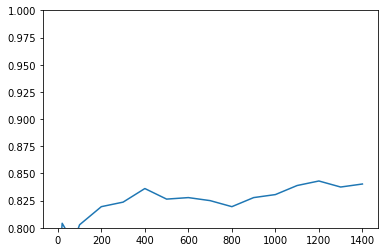

In [233]:
accuracies = []

for train_count in train_counts:
    # Initialize our model with 500 trees
    clf = RandomForestClassifier(n_estimators=500, oob_score=True)

    clf.fit(sk_images[:train_count*6], lc_lab[:train_count*6])
    accuracies.append(clf.score(val_sk_images, val_lc_lab))

plt.plot(train_counts, accuracies)
plt.ylim(.8,1)

In [230]:
clf.score(val_sk_images, val_lc_lab)

0.8402777777777778

#### SVM Model

In [17]:
from sklearn import svm
clf = svm.SVC(gamma='scale')

train_time_start = datetime.datetime.now()

clf.fit(sk_images, lc_lab)

train_time_stop = datetime.datetime.now()
training_time = train_time_stop - train_time_start
print(training_time)
clf.score(val_sk_images, val_lc_lab)

0:00:56.365926


0.9611111111111111

# Evaluate model

In [29]:
dataset_name = '2000test' # '2010val' '2010test' '2000test'

In [39]:
tiles = {}
landsat_datasets = {}
#tiles['028012'] = ['20110103', '20110308', '20110730', '20110831', '20111103']
#tiles['029011'] = ['20110103', '20110308', '20110730', '20110831', '20111018']
#tiles['028011'] = ['20110103', '20110308', '20110831', '20111018', '20111103']

# 2000 tiles
tiles['028012'] = ['20000105', '20000410', '20000816', '20001003', '20001019']
tiles['029011'] = ['20000222', '20000410', '20000816', '20001003', '20001019']
tiles['028011'] = ['20000121', '20000410', '20000512', '20000816', '20001019']

for tile_number, dates in tiles.items():
    tile_datasets = []
    l8_image_paths = []
    for date in dates:
        l8_image_paths.append('/deep_data/recurrent_data/tile{}/combined/combined{}.tif'.format(tile_number, date))
    for fp in l8_image_paths:
        tile_datasets.append(rasterio.open(fp))
    landsat_datasets[tile_number] = tile_datasets

In [52]:
#val_gdf = gpd.read_file('../shapefiles/val_buffered_points140520_val.shp')
#val_gdf = gpd.read_file('../shapefiles/test_buffered_points140520_val.shp')
val_gdf = gpd.read_file('../shapefiles/test1999_buffered_points140520_val_subset.shp')

val_px = []

per_class_count = [0] * 6
total_per_class_count = [0] * 6

for index, row in val_gdf.iterrows():
    if not row['reject']:
        total_per_class_count[int(row['manual_val'])] = total_per_class_count[int(row['manual_val'])] + 1
        if per_class_count[int(row['manual_val'])] < 100:
            per_class_count[int(row['manual_val'])] = per_class_count[int(row['manual_val'])] + 1
            val_px.append(((row['row'], row['col']), row['tile_name'], row['manual_val']))
    
random.shuffle(val_px)

len(val_px), val_px[0]

(600, ((4420.0, 3707.0), '028011', 5))

In [55]:
tile_gen = rnn_tiles.rnn_tile_gen(landsat_datasets, lc_labels, canopy_labels, tile_size, class_count)

val_generator = tile_gen.tile_generator(val_px, batch_size=1, flatten=True, canopy=True)
val_lc_lab = np.empty(len(val_px))
count = 0
val_img_list = []
while count < len(val_px):
    image_b, label_b = next(val_generator)
    val_img_list.append(image_b['tile_input'])
    label_lc = np.argmax(label_b['landcover'], axis=-1)
    val_lc_lab[count] = label_lc
    count += 1

val_sk_images = np.array(val_img_list).reshape(600,-1)

In [56]:
inference_time_start = datetime.datetime.now()

pred_index = clf.predict(val_sk_images)
#clf.score(val_sk_images, val_lc_lab)

inference_time_stop = datetime.datetime.now()
inference_time = inference_time_stop - inference_time_start
print(inference_time)

0:00:00.097036


Accuracy is 0.8416666666666667


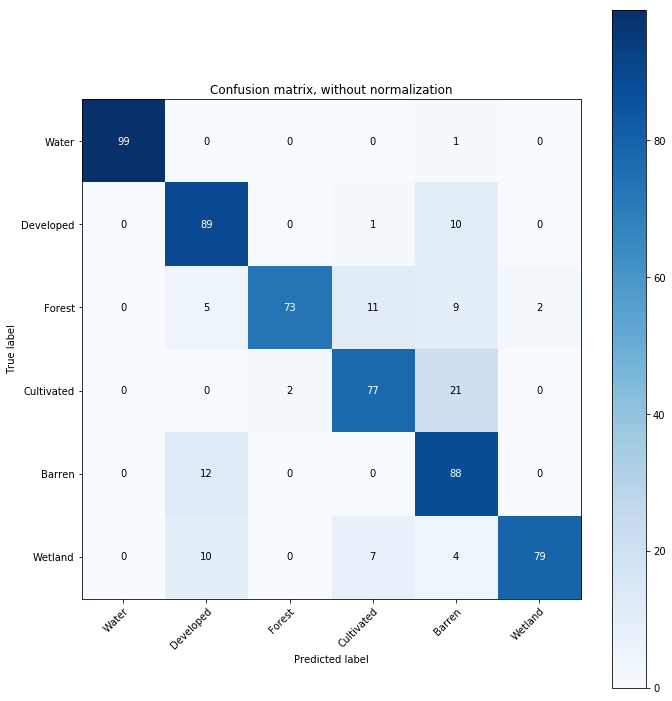

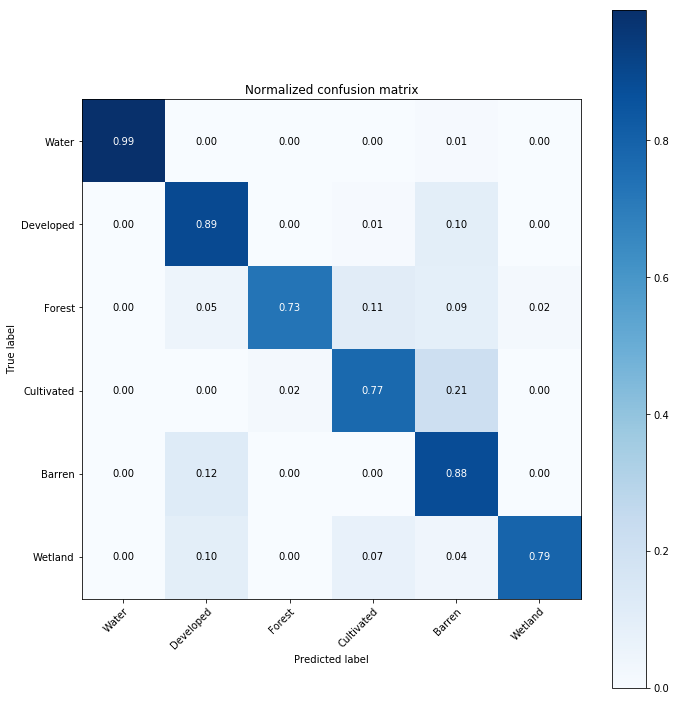

In [57]:
# Plot non-normalized confusion matrix
_, users_acc, prod_acc = util.plot_confusion_matrix(val_lc_lab.astype(np.int), pred_index.astype(np.int), classes=np.array(list(class_dict)), class_dict=class_dict)
experiment.log_figure(figure=plt, figure_name="unnorm_conf_matrix"+ dataset_name)

# Plot normalized confusion matrix
util.plot_confusion_matrix(val_lc_lab.astype(np.int), pred_index.astype(np.int), classes=np.array(list(class_dict)), class_dict=class_dict, normalize=True)
experiment.log_figure(figure=plt, figure_name="norm_conf_matrix"+ dataset_name)

count = 0
for i in range(len(val_lc_lab)):
    if(val_lc_lab[i] == pred_index[i]):
        count+=1

val_accuracy=count/len(val_lc_lab)
class_acc_dict = {}
print("Accuracy is",val_accuracy)

Calculate the accuracy per class
Calculate overall accuracy
Add training samples
add epochs
add tile size

In [44]:
experiment_df = pd.DataFrame(columns=['exp_name','model_name', 'evaluation_dataset', 'time_steps','train_count','overall_acc', 
                                      'epochs', 'tile_size', 'training_time', 'inference_time',
                                      'water_acc_prod','dev_acc_prod', 'forest_acc_prod', 'cult_acc_prod', 'barren_acc_prod', 'wetland_acc_prod',
                                      'water_acc_user','dev_acc_user', 'forest_acc_user', 'cult_acc_user', 'barren_acc_user', 'wetland_acc_user'])   

In [45]:
experiment_df.loc[len(experiment_df)] = [exp_name, model_name, dataset_name, len(tiles['028012']), len(train_px)/class_count, val_accuracy, 
                                         epochs, tile_size, training_time, inference_time] + list(np.round(prod_acc,3)) + list(np.round(users_acc,3))


In [46]:
experiment_df.tail(5)

,exp_name,model_name,evaluation_dataset,time_steps,train_count,overall_acc,epochs,tile_size,training_time,inference_time,...,forest_acc_prod,cult_acc_prod,barren_acc_prod,wetland_acc_prod,water_acc_user,dev_acc_user,forest_acc_user,cult_acc_user,barren_acc_user,wetland_acc_user
0,fullval_sklearn,rf_1,2010test,5,1500.0,0.8125,0,1,00:00:17.021621,00:00:00.134504,...,0.725,0.7,0.875,0.8,0.975,0.748,0.967,0.8,0.593,0.96


In [47]:
experiment_df.to_csv('model_search/' + model_name + '--' + exp_name + dataset_name + '.csv')

In [48]:
all_exps = pd.read_csv('model_search/' + 'all_model_runs.csv')
all_exps = pd.concat([all_exps,experiment_df], ignore_index=True)
all_exps.to_csv('model_search/' + 'all_model_runs.csv')

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


In [49]:
params = {
    "exp_name":exp_name,
    "model_name":model_name,
    "landsat_tiles":tiles,
    "cnn_tile_size":tile_size,
    "class_dict":class_dict,
    "lc_validation_acc":val_accuracy
}
experiment.log_parameters(params)

In [50]:
experiment.end()

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/clifgray/chronos/e630f3b6eef34098bada694c470c2f4f
COMET INFO:   Parameters [count]:
COMET INFO:     algorithm                : auto
COMET INFO:     bootstrap                : True
COMET INFO:     class_dict               : {0: 'Water', 1: 'Developed', 2: 'Forest', 3: 'Cultivated', 4: 'Barren', 5: 'Wetland'}
COMET INFO:     class_weight             : 1
COMET INFO:     cnn_tile_size            : 1
COMET INFO:     criterion                : gini
COMET INFO:     exp_name                 : fullval_sklearn
COMET INFO:     landsat_tiles            : {'028011': ['20000121', '20000410', '20000512', '20000816', '20001019'], '028012': ['20000105', '20000410', '20000816', '20001003', '20001019'], '029011': ['20000222', '20000410', '20000816', '20001003', '200

In [112]:
import joblib
# now you can save it to a file
joblib.dump(clf, 'model_search/' + model_name + '--' + exp_name + '_clf.pkl') 
# and later you can load it
#clf = joblib.load('filename.pkl')

['model_search/rf_1--initial_sklearn_clf.pkl']